# Grid cell + phase offset 
In this Notebook <b>grid cell modules</b> are created as well as functions for the phase decoding using <b>phase offset detectors.</b>  

The starting point has the grid cell activity <b>s_0</b>. After going in a certain direction for predefined a number of time steps the activity <b>t</b> is measured at the end location. (current location)  

Then the phase offset detectors calculates the <b>goal vector</b> toward the original starting point with activity s0.  

The parameters are the same as for Tim.

Definition of tthe grid cell modules, the phase offset detector and other functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#grid cell modules
def create_gm(m):
    M = 5
    g_min = 0.5
    g_max = 6.0
    g_m = g_min *(g_max/g_min)**((m-1)/(M-1))
    
    return g_m

def rec(d):
    llambda = 15
    beta = 3 /(llambda**2)
    gamma = 1.05*beta
    w = np.exp(-gamma*d**2)-np.exp(-beta*d**2)
    return w

def comp_dist(a, b):
    na = int(np.sqrt(len(a)))
    nb = int(np.sqrt(len(b)))
    #print((a))
    a_ = np.tile(a, (nb**2,1))
    b_ = np.tile(b, (na**2,1))
    
    dist1 = np.abs(a_-b_.T)
    dist2 = n - dist1
    return np.minimum(dist1, dist2)

def dynamics(b, s0_, w, tau, dt):
    """Solve the grid cell spiking equation with implicit euler for one time step of size dt"""
    
    f = np.maximum(0, np.tensordot(s0_, w, axes=1) + b)
    s = (s0_ + f * dt / tau) / (1 + dt / tau)
    return s



def create_gc_module():
    #create a set of indeces for the neurons
    n= 40
    x = np.indices((n,n))
    global x_c, y_c
    y_c = np.concatenate(x[0])
    x_c = np.concatenate(x[1])
    
    #incorporate directional preference
    directions = [[1,0],[0,1],[-1,0],[0,-1]]#  E N W S
    z = 2 * (y_c % 2) + x_c % 2
    global g
    g = np.take(directions, z, axis=0) # g is an array with the vector of directional preference for each neuron
    x_s = x_c - g[:, 0]                # subtract to each neuron position the vector of directional preference.
    y_s = y_c - g[:, 1]
    
    # calculate distance matrix and recurrent weights
    xdist = comp_dist(x_c,x_s)
    ydist = comp_dist(y_c,y_s)
    dist_f = np.sqrt(xdist**2+ydist**2)
    global w_rec
    w_rec = rec(dist_f)
    
def calculate_B(v, g, g_m):
    
    alpha = 0.10315
    tau = 1e-1
    dt = 1e-2
    #print(g)
    #print(v)
    B = 1 + g_m * alpha * np.tensordot(g, v, axes=1)
    return B


def init_gc_module(tau, dt):
    nr_steps =1000
    global s
    s = np.random.rand(n**2)*10**(-2)
    
    for i in range(nr_steps):
        v = np.random.rand(2)*0.2
        B = calculate_B(v, g, g_m)
        s = dynamics(B, s, w_rec, tau, dt)
    global s0
    s0 = s
    return s

def  create_shift(direction):
    s = s0
    V= np.array(direction)
    v_sh= np.random.rand(2)*0.2
    dt = 1e-2
    nr_steps_shift =3500
    global original_goal_vec
    original_goal_vec = V*dt*nr_steps_shift
    
    #print(V.shape, v_sh.shape)
    for i in range(nr_steps_shift):
        B = calculate_B(V, g, g_m)
        s = dynamics(B, s, w_rec, tau, dt)
        
        # make the pattern stable
    for i in range(int(nr_steps_shift/10)):
        B = calculate_B(v_sh, g, g_m)
        s = dynamics(B, s, w_rec, tau, dt)
    global t
    t = s
    return t

#POD
def in_(d):
    eta = 0.25
    #print(d.shape)
    beta = 3/ 15**2
    weight_in = eta * ( np.exp(-beta * d**2) - 1 )
    #print(weight_in.shape)
    return weight_in

def ex_(d):
    beta = 3 / 15**2
    weight_ex = np.exp(-beta*d**2)
    return weight_ex

def create_POD():
    n_pod = 10 #size 
    num_dir = 16 # number of directions of  phase offset detectors
    global theta_pod
    theta_pod = np.linspace(0, 2*np.pi, num_dir+1) 
    theta_pod = theta_pod[0:num_dir] 
    x_pod = (np.indices((n_pod,n_pod))+1/2)*(n/(n_pod)) # create the POD and scaling it up to the grid cell dimensions. size n and scaling chosen to cover the whole grid cell
    y_c_pod = np.concatenate(x_pod[0]) # 
    x_c_pod = np.concatenate(x_pod[1]) # 

    xd = comp_dist(x_c_pod, x_c)
    yd = comp_dist(y_c_pod, y_c)
    d = np.sqrt(xd**2+yd**2)
    global w_in, w_ex
    w_in = in_(d)
    
    delta = 7 # 5 for the value 7 i don't get an response from th ephase offset detector for this example shift
    w_ex = np.zeros((n**2, n_pod**2, num_dir))
    for i, angle in enumerate(theta_pod):
        
        y_c_pod_t = y_c + delta * np.sin(angle)
        x_c_pod_t = x_c + delta * np.cos(angle)
        xd = comp_dist(x_c_pod, x_c_pod_t)
        yd = comp_dist(y_c_pod, y_c_pod_t)
        d = np.sqrt(xd**2+yd**2)
        
        w_ex[:, :, i] = ex_(d)
        
def motor_output():
    p = np.empty((n_pod**2, num_dir))
    for idx, angle in enumerate(theta_pod):
        p[:,idx] = np.dot(t,w_in) + np.dot(s0, w_ex[:,:,idx])
    return p
        
def calculate_goal_vec(g_mlist, p_list, num_dir):
    p_array = np.array(p_list)
    g_marray = np.array(g_mlist)
    p_theta = np.sum(np.maximum(0, p_array), axis = 1) #sum activity of all POD with same angle within one module
    xx = 0
    yy = 0
    #create a matrix S_ of g_m factors to divide to the respective module p_array
    S = np.repeat(g_marray[:,np.newaxis], num_dir, axis=1)
    p_theta1 = p_theta/S                              #weight with inverse of g_mFp_theta1
    p_sum = np.sum(p_theta1, axis =0)                    #sum over modules
    rho = 0.33
    for idx, angle in enumerate(theta_pod):
        xx += p_sum[idx] * np.cos(angle) * rho 
        yy += p_sum[idx] * np.sin(angle) * rho 
    THETA = [xx,yy]
    return THETA
    

# Start simulation for M grid cell modules

In [2]:

#create grid cell network

n= 40
M = 1    # can be changed to have more modules for example up to 6 
tau = 1e-1
dt = 1e-2
shift_vel_vec=[0, 0.5] # can be changed for reaching different directions
i = 0

num_dir=16 # number of directions of  phase offset detectors
n_pod = 10 #size  of POD
p_list = []
g_mlist =[]
s_list = []
t_list = []
for m in range(M):
    g_m = create_gm(m)
    g_mlist.append(g_m)
    gc_module = create_gc_module()
    s_list.append(init_gc_module(tau, dt))
    t_list.append(create_shift(shift_vel_vec))
    create_POD()
    p_list.append(motor_output())

goal_vec = calculate_goal_vec(g_mlist, p_list, num_dir)

In [3]:
print("original goal vector is", original_goal_vec, "estimated goal vector is", goal_vec)

original goal vector is [ 0.  17.5] estimated goal vector is [-0.1916035302036554, -16.67563557258488]


Plot of the goal vector.

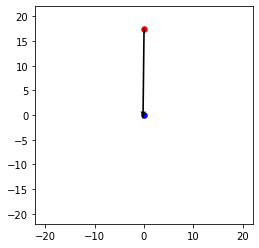

In [4]:
u = np.array(shift_vel_vec)*3500*dt
axes = plt.gca()
axes.xaxis.label.set_size(200)
axes.yaxis.label.set_size(200)
plt.scatter(u[0],u[1], color="red", s=30) #current point
plt.scatter(20,20, color="red", s=0)
plt.scatter(-20,-20, color="red", s=0)
plt.scatter([0],[0], color= "blue", s = 30) #start point
plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(u[0], u[1],*np.array(goal_vec),  scale=40)

The measures used for comparison are the error in the endposition delta, the error in angle alpha and in lenght d of the goal vector.

In [5]:
delta = np.linalg.norm(original_goal_vec+goal_vec)
eps = 0.00001 #to avoid dividing by zero
alpha1 = np.arctan(original_goal_vec[1]/(original_goal_vec[0] + eps))
alpha2 = np.arctan(goal_vec[1]/(goal_vec[0] + eps))
d = np.linalg.norm(original_goal_vec) - np.linalg.norm(goal_vec)
print("delta=", delta, "m","alpha =", alpha1- alpha2, "°", "d=", d, "m")

delta= 0.8463383613980644 m alpha = 0.011488352005647906 ° d= 0.8232636987195612 m


# Simulation for 36 angles
Might take long for more modules.

In [6]:
goal_vecs = []
orig_goal_vecs = []
deltas = []
alphas = []
ds = []
i=0
test_angles = np.linspace(0, 2*np.pi, 36)
for a in range(36):
    #create grid cell network
    
    plot = False
    plot_shift = False
    n= 40
    M = 1
    tau = 1e-1
    dt = 1e-2
    shift_vel_vec=[0.5 * np.sin(test_angles[a]), 0.5 * np.cos(test_angles[a])]
    i +=1

    num_dir=16 # number of directions of  phase offset detectors
    n_pod = 10 #size  of POD
    p_list = []
    g_mlist =[]
    s_list = []
    t_list = []
    for m in range(M):
        g_m = create_gm(m)
        g_mlist.append(g_m)

        gc_module = create_gc_module()
        s_list.append(init_gc_module(tau, dt))
        t_list.append(create_shift(shift_vel_vec))
        
        create_POD()
        p_list.append(motor_output())
        
    goal_vec = calculate_goal_vec(g_mlist, p_list, num_dir)
    
    delta = np.linalg.norm(original_goal_vec+goal_vec)
    eps = 0.00001
    alpha1 = np.arctan(original_goal_vec[1]/(original_goal_vec[0] + eps))
    alpha2 = np.arctan(goal_vec[1]/(goal_vec[0] +eps))
    
    d = np.linalg.norm(original_goal_vec) - np.linalg.norm(goal_vec)
    
    
    goal_vecs.append(goal_vec)
    orig_goal_vecs.append(original_goal_vec)
    deltas.append(delta)
    alphas.append(alpha1-alpha2)
    ds.append(d)
    if i%6 == 0:
        print("trial number", i, "angle", test_angles[a])
        print("delta=", delta,"alpha =", alpha1- alpha2, "d=", d)
    

trial number 6 angle 0.8975979010256552
delta= 2.0482865163715465 alpha = 0.07187374231361643 d= -1.5722644555714673
trial number 12 angle 1.9747153822564414
delta= 0.9392536736027791 alpha = 0.05057288605145477 d= 0.3379840172784725
trial number 18 angle 3.0518328634872276
delta= 1.150886313083542 alpha = 0.06565198266768002 d= 0.11824163445924185
trial number 24 angle 4.128950344718014
delta= 3.8337764394221345 alpha = -0.05175771182086031 d= 3.7487743037523007
trial number 30 angle 5.2060678259488
delta= 2.8550765321139693 alpha = -0.029181953072225264 d= -2.801596652819427
trial number 36 angle 6.283185307179586
delta= 1.6834692393159862 alpha = 0.013973069164107343 d= 1.6673220710467493


In [8]:
de = np.mean(deltas)
alp = np.mean(alphas)
dd = np.mean(ds)
print("mean errors are", de, "m", alp, "°", dd, "m")

mean errors are 2.929185205505197 m -0.005671470978256616 ° -0.7526803938958396 m


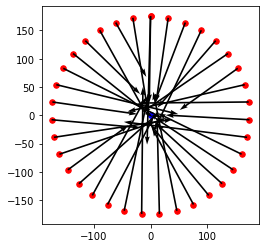

In [9]:
test_angles = np.linspace(0, 2*np.pi, 36)
start_points=[]
v = goal_vecs
for a in range(36):

    start_points.append([175 * np.sin(test_angles[a]), 175 * np.cos(test_angles[a])])


#Plot
V= np.array(v)*10
plt.scatter(np.array(start_points)[:,0], np.array(start_points)[:,1], color="red", s=30)
plt.scatter([0],[0], color= "blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(*np.array(start_points).T, V[:,0], V[:,1],  scale=400)